In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import odr
from uncertainties import unumpy, ufloat
import scienceplots

plt.style.use(['science', 'notebook'])

### Counting a set number of fringes, then measuring the change in distance of the back mirror (micrometers). We took the average of our counts for each measurement

In [2]:
distance_10 = unumpy.uarray([3.4, 3.5], [0.1, 0.1])
distance_26 = unumpy.uarray([8.9, 8.4], [0.1, 0.1])
distance_50 = unumpy.uarray([17.0], [0.1])
distance_55 = unumpy.uarray([17.5], [0.1])
distance_78 = unumpy.uarray([25.5], [0.1])
distance_75 = unumpy.uarray([24.7], [0.1])
distance_102 = unumpy.uarray([33.1], [0.1])
distance_101 = unumpy.uarray([33.7], [0.1])

# Create array of distances
distances = unumpy.uarray([3.4, 3.5, 8.9, 8.4, 17.0, 17.5, 25.5, 24.7, 33.1, 33.7], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

### Use the equation relating path length and number of fringes to determine the wavelength of the monochromatic laser (see equation below)

\begin{equation}
n \lambda = 2 d
\end{equation}

In [3]:
# Define function to calculate wavelength
def wavelength(num_fringes, distance):
    return (2*num_fringes*10**-6)/(distance)

# Calculate wavelengths
wavelength_10_01 = wavelength(distance_10[0], 10)
wavelength_10_02 = wavelength(distance_10[1], 10)
wavelength_26_01 = wavelength(distance_26[0], 26)
wavelength_26_02 = wavelength(distance_26[1], 26)
wavelength_50 = wavelength(distance_50, 50)
wavelength_55 = wavelength(distance_55, 55)
wavelength_78 = wavelength(distance_78, 78)
wavelength_75= wavelength(distance_75, 75)
wavelength_102 = wavelength(distance_102, 102)
wavelength_101 = wavelength(distance_101, 101)

# Calculate average wavelength
wavelength_avg = (wavelength_10_01 + wavelength_10_02 + wavelength_26_01 + wavelength_26_02 + wavelength_50 + wavelength_55 + wavelength_78 + wavelength_75 + wavelength_102 + wavelength_101)/10
print(r"Average wavelength:", wavelength_avg)

Average wavelength: [6.655992028162091e-07+/-3.1129052798873734e-09]


Beta: [0.32670347 0.15670578]
Beta Std Error: [0.00376429 0.23625537]
Beta Covariance: [[ 9.10555691e-07 -4.85324211e-05]
 [-4.85324211e-05  3.58676675e-03]]
Residual Variance: 15.561814225033379
Inverse Condition #: 0.008368990246510848
Reason(s) for Halting:
  Sum of squares convergence
R^2 value: 0.9989390464820361


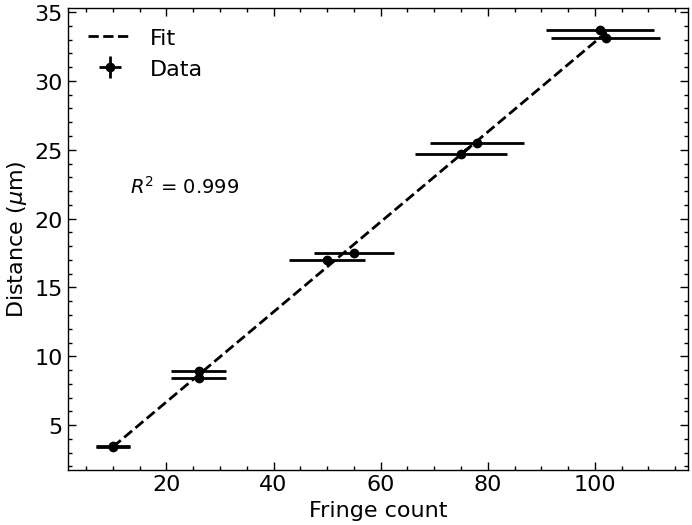

Wavelength from fit: 6.534069344279363e-07
Error in wavelength from fit: 3.764292563721614e-09


In [26]:
# Calculate standard deviation of wavelength
distance_vals = unumpy.nominal_values(distances)
distance_errs = unumpy.std_devs(distances)
fringe_counts = np.array([10, 10, 26, 26, 50, 55, 78, 75, 102, 101])

# Define function to calculate error in wavelength
def fringe_error(num_fringes):
    return np.sqrt(num_fringes)

# Calculate error in wavelength
fringe_err = fringe_error(fringe_counts)

# Fit a line to the data
def linear_func(p, x):
    m, c = p
    return m*x + c

odr_model = odr.Model(linear_func)
data = odr.RealData(fringe_counts, distance_vals, sx=fringe_err, sy=distance_errs)
odr_instance = odr.ODR(data, odr_model, beta0=[1., 1.])
odr_instance.set_job(fit_type=2)
odr_output = odr_instance.run()
popt = odr_output.pprint()

# Calculate R^2 value
residuals = distance_vals - linear_func(odr_output.beta, fringe_counts) 
ss_res = np.sum(residuals**2)
ss_tot = np.sum((distance_vals - np.mean(distance_vals))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r"R^2 value:", r_squared)

# Plot data
plt.plot(fringe_counts, odr_output.beta[0]*fringe_counts + odr_output.beta[1], '--', c='k')
plt.errorbar(fringe_counts, distance_vals, xerr=fringe_err, yerr=distance_errs, fmt='o', c='k')
plt.xlabel(r"Fringe count")
plt.ylabel(r"Distance ($\mu$m)")
plt.annotate("$R^2$ = " + str(round(r_squared, 3)), xy=(0.1, 0.6), xycoords='axes fraction', fontsize=14)
# plt.title(r"Distance vs Fringe count")
plt.legend([r"Fit", r"Data"])
plt.savefig("../figures/distance_vs_fringe_count.pdf")
plt.show()

# Calculate wavelength and error from fit
wavelength_fit = 2*odr_output.beta[0]*10**-6
wavelength_fit_err = odr_output.sd_beta[0]*10**-6
print(r"Wavelength from fit:", wavelength_fit)
print(r"Error in wavelength from fit:", wavelength_fit_err)

### Measured the zeroth order and the second order from both the right and left sides. This was done to determine if the diffraction grating was perpendicular to the incident beam. We took the differences from both second order measurements and the zeroth order, then averaged them out to determine what the angle for both the second order measurements should be for the grating to be considered perpendicular to the incident beam.

In [5]:
# Measurements for diffraction grating

# Calculate band width for bands of light
band_width_left = unumpy.uarray([314 + 18/60], [0.1])
band_width_right = unumpy.uarray([314 + 23/60], [0.1])
band_width_length = unumpy.nominal_values(band_width_right) - unumpy.nominal_values(band_width_left)

zeroth_order_will = unumpy.uarray([118 + 53/60], [1/60 + band_width_length])
zeroth_order_matthew = unumpy.uarray([118 + 53/60], [1/60 + band_width_length])
second_order_right_side_will = unumpy.uarray([172 + 18/60], [1/60 + band_width_length])
second_order_right_side_matthew = unumpy.uarray([172 + 20/60], [1/60 + band_width_length])
second_order_left_side_will = unumpy.uarray([168 + 30/60], [1/60 + band_width_length])
second_order_left_side_matthew = unumpy.uarray([], [1/60 +  band_width_length])

In [6]:
def diffraction_grating_calc(order, wavelength, angle):
    return (order*wavelength)/(unumpy.sin(angle*np.pi/180))

diffraction_grating_will = diffraction_grating_calc(2, wavelength_avg, second_order_right_side_will - zeroth_order_will)
print(r"Diffraction grating constant (Will):", diffraction_grating_will)
diffraction_grating_matthew = diffraction_grating_calc(2, wavelength_avg, second_order_right_side_matthew - zeroth_order_matthew)
print(r"Diffraction grating constant (Matthew):", diffraction_grating_matthew)

Diffraction grating constant (Will): [[1.6578001636193154e-06+/-8.326887546470917e-09]]
Diffraction grating constant (Matthew): [[1.6570849102160255e-06+/-8.321950228725444e-09]]


In [7]:
# Try measuring the diffraction grating now that it is perpendicular to the incident light within 1 minute of error

second_order_left_side_will = unumpy.uarray([52 + 33/60], [1/60 + band_width_length])
diffraction_grating_second_order_left_side_will = diffraction_grating_calc(2, wavelength_avg, second_order_left_side_will)

first_order_left_side_matthew = unumpy.uarray([23 + 33/60], [1/60 + band_width_length])
diffraction_grating_matthew_first_order_left_side_matthew = diffraction_grating_calc(1, wavelength_avg, first_order_left_side_matthew)

first_order_right_side_matthew = unumpy.uarray([23 + 4/60], [1/60 + band_width_length])
diffraction_grating_first_order_right_side_matthew = diffraction_grating_calc(1, wavelength_avg, first_order_right_side_matthew)

second_order_right_side_matthew = unumpy.uarray([51 + 38/60], [1/60 + band_width_length])
diffraction_grating_second_order_right_side_matthew = diffraction_grating_calc(2, wavelength_avg, second_order_right_side_matthew)

# Average the diffraction grating constants
diffraction_grating_avg = (diffraction_grating_will + diffraction_grating_matthew + diffraction_grating_second_order_left_side_will + diffraction_grating_matthew_first_order_left_side_matthew + diffraction_grating_first_order_right_side_matthew + diffraction_grating_second_order_right_side_matthew)/6
print(r"Average diffraction grating constant:", diffraction_grating_avg)

# Calculate slits per mm
slits_per_mm = 1/diffraction_grating_avg*10**-3
print(r"Slits per mm:", slits_per_mm)

Average diffraction grating constant: [[1.675705244323725e-06+/-8.050190172794277e-09]]
Slits per mm: [[596.7636631725028+/-2.8668890265905933]]


# Helium

\begin{equation}
n \lambda = d \sin(\theta),
\end{equation}

where $n$ is the diffraction order, $\lambda$ is the wavelength of light, $d$ is the diffraction grating, and $\theta$ is the measured angle.

In [8]:
# Calculate wavelength from order and angle
def wavelength_calc(order, angle):
    return (diffraction_grating_avg)*unumpy.sin(angle*np.pi/180)/order


# Zeroth order
zeroth_order = unumpy.uarray([134 + 54/60], [1/60 + band_width_length])


# First order left side
first_order_left_violet = unumpy.uarray([119 + 19/60], [1/60 + band_width_length])
first_order_left_violet_wavelength = wavelength_calc(1, zeroth_order - first_order_left_violet)
print("First order left violet wavelength:", first_order_left_violet_wavelength)

first_order_left_blue = unumpy.uarray([118 + 29/60], [1/60 + band_width_length])
first_order_left_blue_wavelength = wavelength_calc(1, zeroth_order - first_order_left_blue)
print("First order left blue wavelength:", first_order_left_blue_wavelength)

first_order_left_cyan = unumpy.uarray([117 + 44/60], [1/60 + band_width_length])
first_order_left_cyan_wavelength = wavelength_calc(1, zeroth_order - first_order_left_cyan)
print("First order left cyan wavelength:", first_order_left_cyan_wavelength)

first_order_left_green = unumpy.uarray([117 + 22/60], [1/60 + band_width_length])
first_order_left_green_wavelength = wavelength_calc(1, zeroth_order - first_order_left_green)
print("First order left green wavelength:", first_order_left_green_wavelength)

first_order_left_orange = unumpy.uarray([114 + 14/60], [1/60 + band_width_length])
first_order_left_orange_wavelength = wavelength_calc(1, zeroth_order - first_order_left_orange)
print("First order left orange wavelength:", first_order_left_orange_wavelength)

first_order_left_red = unumpy.uarray([111 + 16/60], [1/60 + band_width_length])
first_order_left_red_wavelength = wavelength_calc(1, zeroth_order - first_order_left_red)
print("First order left red wavelength #1:", first_order_left_red_wavelength)

first_order_left_red_2 = unumpy.uarray([109 + 50/60], [1/60 + band_width_length])
first_order_left_red_wavelength_2 = wavelength_calc(1, zeroth_order - first_order_left_red_2)
print("First order left red wavelength #2:", first_order_left_red_wavelength_2)

He_violet = first_order_left_violet_wavelength
He_blue = first_order_left_blue_wavelength
He_cyan = first_order_left_cyan_wavelength
He_green = first_order_left_green_wavelength
He_orange = first_order_left_orange_wavelength
He_red = (first_order_left_red_wavelength + first_order_left_red_wavelength_2)/2
He_red_2 = first_order_left_red_wavelength_2

# Second order left side
second_order_left_violet = unumpy.uarray([102 + 30/60], [1/60 + band_width_length])
second_order_left_violet_wavelength = wavelength_calc(2, zeroth_order - second_order_left_violet)
print("\nSecond order left violet wavelength:", second_order_left_violet_wavelength)

second_order_left_blue = unumpy.uarray([100 + 39/60], [1/60 + band_width_length])
second_order_left_blue_wavelength = wavelength_calc(2, zeroth_order - second_order_left_blue)
print("Second order left blue wavelength:", second_order_left_blue_wavelength)

second_order_left_cyan = unumpy.uarray([98 + 44/60], [1/60 + band_width_length])
second_order_left_cyan_wavelength = wavelength_calc(2, zeroth_order - second_order_left_cyan)
print("Second order left cyan wavelength:", second_order_left_cyan_wavelength)

second_order_left_green = unumpy.uarray([97 + 59/60], [1/60 + band_width_length])
second_order_left_green_wavelength = wavelength_calc(2, zeroth_order - second_order_left_green)
print("Second order left green wavelength:", second_order_left_green_wavelength)

second_order_left_orange = unumpy.uarray([90 + 13/60], [1/60 + band_width_length])
second_order_left_orange_wavelength = wavelength_calc(2, zeroth_order - second_order_left_orange)
print("Second order left orange wavelength:", second_order_left_orange_wavelength)

second_order_left_red = unumpy.uarray([81 + 59/60], [1/60 + band_width_length])
second_order_left_red_wavelength = wavelength_calc(2, zeroth_order - second_order_left_red)
print(r"Second order left red wavelength #1:", second_order_left_red_wavelength)


# First order right side
first_order_right_violet = unumpy.uarray([150 + 41/60], [1/60 + band_width_length])
first_order_right_violet_wavelength = wavelength_calc(1, first_order_right_violet - zeroth_order)
print("\nFirst order right violet wavelength:", first_order_right_violet_wavelength)

first_order_right_blue = unumpy.uarray([151 + 30/60], [1/60 + band_width_length])
first_order_right_blue_wavelength = wavelength_calc(1, first_order_right_blue - zeroth_order)
print("First order right blue wavelength:", first_order_right_blue_wavelength)

first_order_right_cyan = unumpy.uarray([152 + 15/60], [1/60 + band_width_length])
first_order_right_cyan_wavelength = wavelength_calc(1, first_order_right_cyan - zeroth_order)
print("First order right cyan wavelength:", first_order_right_cyan_wavelength)

first_order_right_green = unumpy.uarray([152 + 32/60], [1/60 + band_width_length])
first_order_right_green_wavelength = wavelength_calc(1, first_order_right_green - zeroth_order)
print("First order right green wavelength:", first_order_right_green_wavelength)

first_order_right_orange = unumpy.uarray([155 + 47/60], [1/60 + band_width_length])
first_order_right_orange_wavelength = wavelength_calc(1, first_order_right_orange - zeroth_order)
print("First order right orange wavelength:", first_order_right_orange_wavelength)

first_order_right_red = unumpy.uarray([158 + 52/60], [1/60 + band_width_length])
first_order_right_red_wavelength = wavelength_calc(1, first_order_right_red - zeroth_order)
print("First order right red wavelength:", first_order_right_red_wavelength)

first_order_right_red_2 = unumpy.uarray([160 + 21/60], [1/60 + band_width_length])
first_order_right_red_wavelength_2 = wavelength_calc(1, first_order_right_red_2 - zeroth_order)
print(r"First order right red wavelength #2:", first_order_right_red_wavelength_2)


# Second order right side
second_order_right_violet = unumpy.uarray([167 + 54/60], [1/60 + band_width_length])
second_order_right_violet_wavelength = wavelength_calc(2, second_order_right_violet - zeroth_order)
print("\nSecond order right violet wavelength:", second_order_right_violet_wavelength)

second_order_right_blue = unumpy.uarray([169 + 55/60], [1/60 + band_width_length])
second_order_right_blue_wavelength = wavelength_calc(2, second_order_right_blue - zeroth_order)
print("Second order right blue wavelength:", second_order_right_blue_wavelength)

second_order_right_cyan = unumpy.uarray([171 + 39/60], [1/60 + band_width_length])
second_order_right_cyan_wavelength = wavelength_calc(2, second_order_right_cyan - zeroth_order)
print("Second order right cyan wavelength:", second_order_right_cyan_wavelength)

second_order_right_green = unumpy.uarray([172 + 30/60], [1/60 + band_width_length])
second_order_right_green_wavelength = wavelength_calc(2, second_order_right_green - zeroth_order)
print("Second order right green wavelength:", second_order_right_green_wavelength)

second_order_right_orange = unumpy.uarray([183 + 7/60], [1/60 + band_width_length])
second_order_right_orange_wavelength = wavelength_calc(2, second_order_right_orange - zeroth_order)
print("Second order right orange wavelength:", second_order_right_orange_wavelength)

second_order_right_red = unumpy.uarray([189 + 32/60], [1/60 + band_width_length])
second_order_right_red_wavelength = wavelength_calc(2, second_order_right_red - zeroth_order)
print("Second order right red wavelength:", second_order_right_red_wavelength)


# Third order right side
third_order_right_violet = unumpy.uarray([189 + 59/60], [1/60 + band_width_length])
third_order_right_violet_wavelength = wavelength_calc(3, third_order_right_violet - zeroth_order)
print("\nThird order right violet wavelength:", third_order_right_violet_wavelength)

First order left violet wavelength: [[4.501608478973365e-07+/-4.5331554569272645e-09]]
First order left blue wavelength: [[4.735886506808852e-07+/-4.573523118681057e-09]]
First order left cyan wavelength: [[4.945881591382619e-07+/-4.611124959974512e-09]]
First order left green wavelength: [[5.048239650067847e-07+/-4.629929078139272e-09]]
First order left orange wavelength: [[5.91407598173164e-07+/-4.80088987266913e-09]]
First order left red wavelength #1: [[6.717602088398205e-07+/-4.977214988287186e-09]]
First order left red wavelength #2: [[7.099502509304645e-07+/-5.066459675763559e-09]]

Second order left violet wavelength: [[4.4894388519773905e-07+/-2.774974018122896e-09]]
Second order left blue wavelength: [[4.715475844349306e-07+/-2.837941827483474e-09]]
Second order left cyan wavelength: [[4.944470764862718e-07+/-2.903389736239337e-09]]
Second order left green wavelength: [[5.032585392051741e-07+/-2.9289939923337896e-09]]
Second order left orange wavelength: [[5.891678341558749e-

### Make plot for helium spectrum

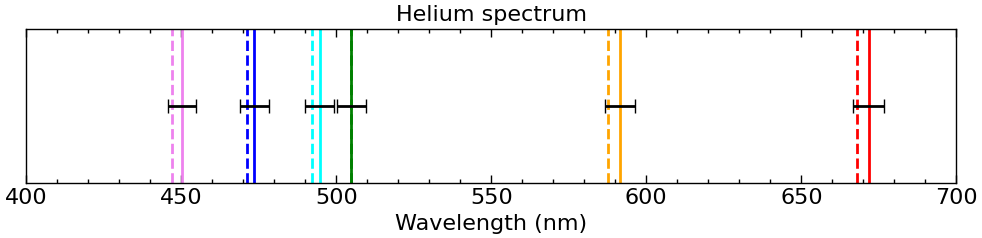

In [9]:
# First order helium spectrum
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 2))
ax.set_title(r"Helium spectrum")
ax.set_xlabel(r"Wavelength (nm)")
ax.set_xlim(400, 700)
ax.set_yticks([])

# First order helium from our measurements
ax.axvline((unumpy.nominal_values(first_order_left_violet_wavelength))*10**9, c='violet', label='Violet')
ax.axvline((unumpy.nominal_values(first_order_left_blue_wavelength))*10**9, c='blue', label='Blue')
ax.axvline((unumpy.nominal_values(first_order_left_cyan_wavelength))*10**9, c='cyan', label='Cyan')
ax.axvline((unumpy.nominal_values(first_order_left_green_wavelength))*10**9, c='green', label='Green')
ax.axvline((unumpy.nominal_values(first_order_left_orange_wavelength))*10**9, c='orange', label='Orange')
ax.axvline((unumpy.nominal_values(first_order_left_red_wavelength))*10**9, c='red', label='Red')

# First order helium from literature (http://hyperphysics.phy-astr.gsu.edu/hbase/Tables/hydspec.html#c1)
ax.axvline(447.148, c='violet', ls='--', label='Violet (Lit.)')
ax.axvline(471.314, c='blue', ls='--', label='Blue (Lit.)')
ax.axvline(492.193, c='cyan', ls='--', label='Cyan (Lit.)')
ax.axvline(504.774, c='green', ls='--', label='Green (Lit.)')
ax.axvline(587.562, c='orange', ls='--', label='Orange (Lit.)')
ax.axvline(667.815, c='red', ls='--', label='Red (Lit.)')

# First order helium from our measurements error bars
ax.errorbar((unumpy.nominal_values(first_order_left_violet_wavelength))*10**9, 0, xerr=(unumpy.std_devs(first_order_left_violet_wavelength))*10**9, fmt='None', c='k', capsize=5)
ax.errorbar((unumpy.nominal_values(first_order_left_blue_wavelength))*10**9, 0, xerr=(unumpy.std_devs(first_order_left_blue_wavelength))*10**9, fmt='None', c='k', capsize=5)
ax.errorbar((unumpy.nominal_values(first_order_left_cyan_wavelength))*10**9, 0, xerr=(unumpy.std_devs(first_order_left_cyan_wavelength))*10**9, fmt='None', c='k', capsize=5)
ax.errorbar((unumpy.nominal_values(first_order_left_green_wavelength))*10**9, 0, xerr=(unumpy.std_devs(first_order_left_green_wavelength))*10**9, fmt='None', c='k', capsize=5)
ax.errorbar((unumpy.nominal_values(first_order_left_orange_wavelength))*10**9, 0, xerr=(unumpy.std_devs(first_order_left_orange_wavelength))*10**9, fmt='None', c='k', capsize=5)
ax.errorbar((unumpy.nominal_values(first_order_left_red_wavelength))*10**9, 0, xerr=(unumpy.std_devs(first_order_left_red_wavelength))*10**9, fmt='None', c='k', capsize=5)

plt.savefig("../figures/helium_spectrum_first_order.pdf", bbox_inches='tight')
plt.show()

# Hydrogen

\begin{equation}
n \lambda = d \sin(\theta),
\end{equation}

where $n$ is the diffraction order, $\lambda$ is the wavelength of light, $d$ is the diffraction grating, and $\theta$ is the measured angle.

In [10]:
# First order left side

zeroth_order = unumpy.uarray([134 + 53/60], [1/60 + band_width_length])


# First order left side
first_order_left_violet = unumpy.uarray([119 + 9/60], [1/60 + band_width_length])
first_order_left_violet_wavelength = wavelength_calc(1, zeroth_order - first_order_left_violet)
print("First order left violet wavelength:", first_order_left_violet_wavelength)

first_order_left_cyan = unumpy.uarray([117 + 56/60], [1/60 + band_width_length])
first_order_left_cyan_wavelength = wavelength_calc(1, zeroth_order - first_order_left_cyan)
print("First order left cyan wavelength:", first_order_left_cyan_wavelength)

first_order_left_red = unumpy.uarray([111 + 8/60], [1/60 + band_width_length])
first_order_left_red_wavelength = wavelength_calc(1, zeroth_order - first_order_left_red)
print("First order left red wavelength:", first_order_left_red_wavelength)

H_violet = first_order_left_violet_wavelength
H_cyan = first_order_left_cyan_wavelength
H_red = first_order_left_red_wavelength

# Second order left side
second_order_left_violet = unumpy.uarray([104 + 30/60], [1/60 + band_width_length])
second_order_left_violet_wavelength = wavelength_calc(2, zeroth_order - second_order_left_violet)
print("\nSecond order left violet wavelength:", second_order_left_violet_wavelength)

second_order_left_cyan = unumpy.uarray([99 + 12/60], [1/60 + band_width_length])
second_order_left_cyan_wavelength = wavelength_calc(2, zeroth_order - second_order_left_cyan)
print("Second order left cyan wavelength:", second_order_left_cyan_wavelength)

second_order_left_red = unumpy.uarray([83 + 8/60], [1/60 + band_width_length])
second_order_left_red_wavelength = wavelength_calc(2, zeroth_order - second_order_left_red)
print("Second order left red wavelength:", second_order_left_red_wavelength)


# zero = unumpy.uarray([310 + 36/60], [1/60 + band_width_length])

# violet_line = unumpy.uarray([325 + 50/60], [1/60 + band_width_length])

# red_line = unumpy.uarray([334 + 7/60], [1/60 + band_width_length])


# First order right side
first_order_right_violet = unumpy.uarray([150 + 10/60], [1/60 + band_width_length])
first_order_right_violet_wavelength = wavelength_calc(1, first_order_right_violet - zeroth_order)
print("\nFirst order right violet wavelength:", first_order_right_violet_wavelength)

first_order_right_cyan = unumpy.uarray([152 + 0/60], [1/60 + band_width_length])
first_order_right_cyan_wavelength = wavelength_calc(1, first_order_right_cyan - zeroth_order)
print("First order right cyan wavelength:", first_order_right_cyan_wavelength)

first_order_right_red = unumpy.uarray([158 + 20/60], [1/60 + band_width_length])
first_order_right_red_wavelength = wavelength_calc(1, first_order_right_red - zeroth_order)
print("First order right red wavelength:", first_order_right_red_wavelength)


# Second order right side
second_order_right_violet = unumpy.uarray([166 + 49/60], [1/60 + band_width_length])
second_order_right_violet_wavelength = wavelength_calc(2, second_order_right_violet - zeroth_order)
print("\nSecond order right violet wavelength:", second_order_right_violet_wavelength)

second_order_right_cyan = unumpy.uarray([171 + 8/60], [1/60 + band_width_length])
second_order_right_cyan_wavelength = wavelength_calc(2, second_order_right_cyan - zeroth_order)
print("Second order right cyan wavelength:", second_order_right_cyan_wavelength)

second_order_right_red = unumpy.uarray([188 + 1/60], [1/60 + band_width_length])
second_order_right_red_wavelength = wavelength_calc(2, second_order_right_red - zeroth_order)
print("Second order right red wavelength:", second_order_right_red_wavelength)

First order left violet wavelength: [[4.543850241546811e-07+/-4.540308771487357e-09]]
First order left cyan wavelength: [[4.885301806408718e-07+/-4.600141934612045e-09]]
First order left red wavelength: [[6.748847403303064e-07+/-4.984389899443465e-09]]

Second order left violet wavelength: [[4.237714851557989e-07+/-2.7069008506194322e-09]]
Second order left cyan wavelength: [[4.887235912183591e-07+/-2.886881586665977e-09]]
Second order left red wavelength: [[6.579798497665381e-07+/-3.410420705862057e-09]]

First order right violet wavelength: [[4.4170326829968194e-07+/-4.519000760110675e-09]]
First order right cyan wavelength: [[4.931907886975109e-07+/-4.608581868195108e-09]]
First order right red wavelength: [[6.668446084536117e-07+/-4.965973829203363e-09]]

Second order right violet wavelength: [[4.431671946653142e-07+/-2.7591558379732978e-09]]
Second order right cyan wavelength: [[4.954303393910364e-07+/-2.906235578171671e-09]]
Second order right red wavelength: [[6.703104451850298e

## Make plot for hydrogen spectrum

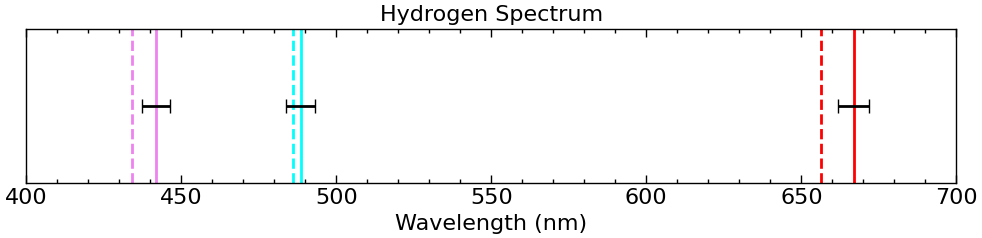

In [11]:
# First order hydrogen spectrum
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 2))
ax.set_title("Hydrogen Spectrum")
ax.set_xlabel("Wavelength (nm)")
ax.set_xlim(400, 700)
ax.set_yticks([])

# First order hydrogen from our measurements
ax.axvline((unumpy.nominal_values(first_order_right_violet_wavelength))*10**9, c='violet', label='Violet')
ax.axvline((unumpy.nominal_values(first_order_left_cyan_wavelength))*10**9, c='cyan', label='Cyan')
ax.axvline((unumpy.nominal_values(first_order_right_red_wavelength))*10**9, c='red', label='Red')

# First order hydrogen from literature (http://hyperphysics.phy-astr.gsu.edu/hbase/quantum/atspect.html)
ax.axvline(434.0, c='violet', label='Violet', linestyle='--')
ax.axvline(486.133, c='cyan', label='Cyan', linestyle='--')
ax.axvline(656.272, c='red', label='Red', linestyle='--')

# First order hydrogen from our measurements error bars
ax.errorbar(unumpy.nominal_values(first_order_right_violet_wavelength)*10**9, 0, xerr=unumpy.std_devs(first_order_left_violet_wavelength)*10**9, fmt='None', c='k', capsize=5)
ax.errorbar(unumpy.nominal_values(first_order_left_cyan_wavelength)*10**9, 0, xerr=unumpy.std_devs(first_order_left_cyan_wavelength)*10**9, fmt='None', c='k', capsize=5)
ax.errorbar(unumpy.nominal_values(first_order_right_red_wavelength)*10**9, 0, xerr=unumpy.std_devs(first_order_left_red_wavelength)*10**9, fmt='None', c='k', capsize=5)

plt.savefig("../figures/hydrogen_spectrum_first_order.pdf", bbox_inches='tight')
plt.show()

## Determining angle of minimal deviation:

Kept scope in same spot

Moved the base cw and measured angle where lines stopped moving

Moved the base ccw and measured angle where lines stopped moving

In [12]:
stopped_angle_cw  = unumpy.uarray([254 + 17/60], [1/60 + band_width_length])
stopped_angle_ccw = unumpy.uarray([255 + 47/60], [1/60 + band_width_length])

mean_stopped_angle = (stopped_angle_cw + stopped_angle_ccw)/2
std_dev_stopped_angle = ((stopped_angle_cw[0] - mean_stopped_angle[0])**2 + (stopped_angle_ccw[0] - mean_stopped_angle[0])**2/2)**0.5
print("Mean stopped angle:", mean_stopped_angle)
print("Standard deviation of stopped angle:", std_dev_stopped_angle)

Mean stopped angle: [[255.03333333333333+/-0.07071067811864135]]
Standard deviation of stopped angle: [0.9185586535436918+/-0.08660254037842745]


# Helium with prism

In [13]:
zeroth_order = unumpy.uarray([314 + 18/60], [1/60 + band_width_length])

helium_violet_angle = unumpy.uarray([252 + 7/60], [1/60 + band_width_length])
helium_blue_angle = unumpy.uarray([252 + 57/60], [1/60 + band_width_length])
helium_cyan_angle = unumpy.uarray([253 + 36/60], [1/60 + band_width_length])
helium_green_angle = unumpy.uarray([253 + 50/60], [1/60 + band_width_length])
helium_orange_angle = unumpy.uarray([255 + 26/60], [1/60 + band_width_length])
helium_red_angle = unumpy.uarray([256 + 21/60], [1/60 + band_width_length])
helium_red_angle_2 = unumpy.uarray([256 + 40/60], [1/60 + band_width_length])

# Hydrogen with prism

In [14]:
hydrogen_violet_angle = unumpy.uarray([251 + 34/60], [1/60 + band_width_length])
hydrogen_cyan_angle = unumpy.uarray([253 + 27/60], [1/60 + band_width_length])
hydrogen_red_angle = unumpy.uarray([256 + 14/60], [1/60 + band_width_length])

# Apex Angle
The apex angle is half the difference between the reflection angles on either side of the prism, with the apex corner facing directly towards the light source.

\begin{equation}
\alpha = \frac{1}{2} \phi \text{,}
\end{equation}

where $\alpha$ is the apex angle, and $\phi$ is the angle between the refected beams.

\begin{equation}
n = \frac{\sin[(\delta _m + \alpha) /2]}{\sin \alpha/2}
\end{equation}

In [15]:
# Calculate apex angle
zero_angle = unumpy.uarray([314 + 41/60], [1/60 + band_width_length])
right_reflection_angle = unumpy.uarray([19 + 6/60], [1/60 + band_width_length])
left_reflection_angle = unumpy.uarray([259 + 7/60], [1/60 + band_width_length])

apex_angle = 0.5*np.abs((360 - zero_angle + right_reflection_angle) + (zero_angle - left_reflection_angle))
print("Apex angle:", apex_angle)

# Define function to calculate index of refraction
def index_of_refraction(min_dev_angle, apex_angle):
    return unumpy.sin((min_dev_angle*np.pi/180 + apex_angle*np.pi/180)/2)/unumpy.sin((apex_angle*np.pi/180)/2)

# Indices of refraction from helium spectrum
helium_violet_index = index_of_refraction(zero_angle - helium_violet_angle, apex_angle)
print("\nHelium violet index of refraction:", helium_violet_index)
helium_blue_index = index_of_refraction(zero_angle - helium_blue_angle, apex_angle)
print("Helium blue index of refraction:", helium_blue_index)
helium_cyan_index = index_of_refraction(zero_angle - helium_cyan_angle, apex_angle)
print("Helium cyan index of refraction:", helium_cyan_index)
helium_green_index = index_of_refraction(zero_angle - helium_green_angle, apex_angle)
print("Helium green index of refraction:", helium_green_index)
helium_orange_index = index_of_refraction(zero_angle - helium_orange_angle, apex_angle)
print("Helium orange index of refraction:", helium_orange_index)
helium_red_index = index_of_refraction(zero_angle - helium_red_angle, apex_angle)
print("Helium red index of refraction:", helium_red_index)
helium_red_index_2 = index_of_refraction(zero_angle - helium_red_angle_2, apex_angle)
print("Helium red index of refraction #2:", helium_red_index_2)

# Indices of refraction from hydrogen spectrum
hydrogen_violet_index = index_of_refraction(zero_angle - hydrogen_violet_angle, apex_angle)
print("\nHydrogen violet index of refraction:", hydrogen_violet_index)
hydrogen_cyan_index = index_of_refraction(zero_angle - hydrogen_cyan_angle, apex_angle)
print("Hydrogen cyan index of refraction:", hydrogen_cyan_index)
hydrogen_red_index = index_of_refraction(zero_angle - hydrogen_red_angle, apex_angle)
print("Hydrogen red index of refraction:", hydrogen_red_index)

indices_of_refraction_H = [unumpy.nominal_values(hydrogen_violet_index), unumpy.nominal_values(hydrogen_cyan_index), unumpy.nominal_values(hydrogen_red_index)]
indices_of_refraction_H_err = [unumpy.std_devs(hydrogen_violet_index), unumpy.std_devs(hydrogen_cyan_index), unumpy.std_devs(hydrogen_red_index)]

# Calculate average index of refraction
index_of_refraction_avg = (helium_violet_index + helium_blue_index + helium_cyan_index + helium_green_index + helium_orange_index + helium_red_index + helium_red_index_2 + hydrogen_violet_index + hydrogen_cyan_index + hydrogen_red_index)/10
print("\nAverage index of refraction:", index_of_refraction_avg)

Apex angle: [[59.99166666666666+/-0.07071067811864135]]

Helium violet index of refraction: [[1.7541639391939077+/-0.0017466499312843132]]
Helium blue index of refraction: [[1.7471275301101423+/-0.0017461721008571569]]
Helium cyan index of refraction: [[1.7415749703426262+/-0.0017459273818464425]]
Helium green index of refraction: [[1.7395680663235913+/-0.00174586691298502]]
Helium orange index of refraction: [[1.7256125822807238+/-0.0017458421029778004]]
Helium red index of refraction: [[1.7174654969722443+/-0.0017461344527386045]]
Helium red index of refraction #2: [[1.7146254819485358+/-0.0017462873134004937]]

Hydrogen violet index of refraction: [[1.7587571735072525+/-0.0017470661853996538]]
Hydrogen cyan index of refraction: [[1.7428613103795545+/-0.0017459738939549893]]
Hydrogen red index of refraction: [[1.718508513303517+/-0.0017460848475863437]]

Average index of refraction: [[1.7360265064362097+/-0.0015398588477200956]]


Beta: [1.68774069 0.01357371]
Beta Std Error: [0.00241176 0.00064768]
Beta Covariance: [[ 3.48470544e-06 -8.93935228e-07]
 [-8.93935228e-07  2.51312740e-07]]
Residual Variance: 1.6691763045973291
Inverse Condition #: 0.06695040979678887
Reason(s) for Halting:
  Sum of squares convergence
R^2 value: 0.9821053259404573


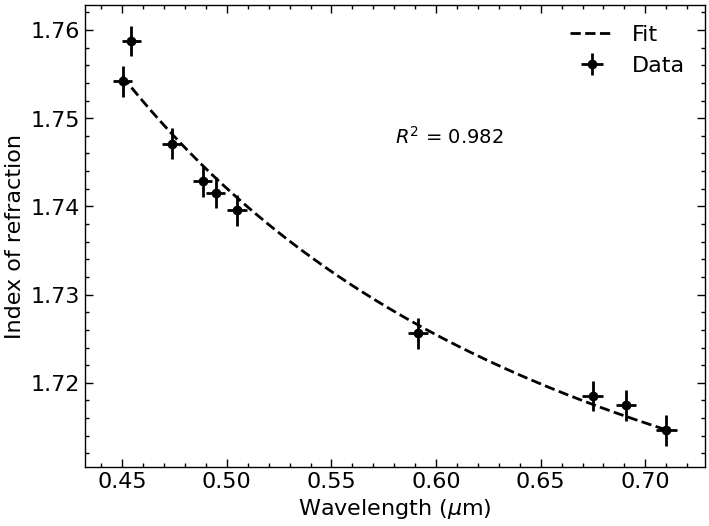

In [81]:
# Make plot of indices of refraction vs wavelength for helium and hydrogen

wavelengths = np.array([unumpy.nominal_values(He_violet), unumpy.nominal_values(H_violet), unumpy.nominal_values(He_blue), unumpy.nominal_values(H_cyan), unumpy.nominal_values(He_cyan), unumpy.nominal_values(He_green), unumpy.nominal_values(He_orange), unumpy.nominal_values(H_red), unumpy.nominal_values(He_red), unumpy.nominal_values(He_red_2)])

wavelength_err = np.array([unumpy.std_devs(He_violet), unumpy.std_devs(H_violet), unumpy.std_devs(He_blue), unumpy.std_devs(H_cyan), unumpy.std_devs(He_cyan), unumpy.std_devs(He_green), unumpy.std_devs(He_orange), unumpy.std_devs(H_red), unumpy.std_devs(He_red), unumpy.std_devs(He_red_2)])

indices_of_refraction = np.array([unumpy.nominal_values(helium_violet_index), unumpy.nominal_values(hydrogen_violet_index), unumpy.nominal_values(helium_blue_index), unumpy.nominal_values(hydrogen_cyan_index), unumpy.nominal_values(helium_cyan_index), unumpy.nominal_values(helium_green_index), unumpy.nominal_values(helium_orange_index), unumpy.nominal_values(hydrogen_red_index), unumpy.nominal_values(helium_red_index), unumpy.nominal_values(helium_red_index_2)])

index_err = np.array([unumpy.std_devs(helium_violet_index), unumpy.std_devs(hydrogen_violet_index), unumpy.std_devs(helium_blue_index), unumpy.std_devs(hydrogen_cyan_index), unumpy.std_devs(helium_cyan_index), unumpy.std_devs(helium_green_index), unumpy.std_devs(helium_orange_index), unumpy.std_devs(hydrogen_red_index), unumpy.std_devs(helium_red_index), unumpy.std_devs(helium_red_index_2)])


# Fit a line to the data and plot (use Cauchey's equation)
def f1(p, x):
    return p[0] + p[1]*x**(-2)

odr_model = odr.Model(f1)
data = odr.RealData(wavelengths.flatten()*10**6, indices_of_refraction.flatten(), sx=wavelength_err.flatten()*10**6, sy=index_err.flatten())
odr_instance = odr.ODR(data, odr_model, beta0=[1, 1])
odr_instance.set_job(fit_type=2)
odr_output = odr_instance.run()
popt = odr_output.pprint()

# Calculate R^2 value
residuals = indices_of_refraction.flatten() - f1(odr_output.beta, wavelengths.flatten()*10**6)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((indices_of_refraction.flatten() - np.mean(indices_of_refraction.flatten()))**2)
r_squared = 1 - (ss_res/ss_tot)
print("R^2 value:", r_squared)

# Generate wavelength values
wavelength_vals = np.linspace(450, 710, 1000)

fig, ax = plt.subplots()
ax.errorbar(wavelengths.flatten()*10**6, indices_of_refraction.flatten(), xerr=wavelength_err.flatten()*10**6, yerr=index_err.flatten(), fmt='o', c='k', label='Data')
ax.plot(wavelength_vals*10**-3, f1(odr_output.beta, wavelength_vals*10**-3), c='k', ls='--', label='Fit')
ax.set_xlabel(r"Wavelength ($\mu$m)")
ax.set_ylabel(r"Index of refraction")
ax.annotate("$R^2$ = " + str(round(r_squared, 3)), xy=(0.5, 0.7), xycoords='axes fraction', fontsize=14)
ax.legend()
plt.savefig("../figures/index_of_refraction_vs_wavelength.pdf", bbox_inches='tight')
plt.show()

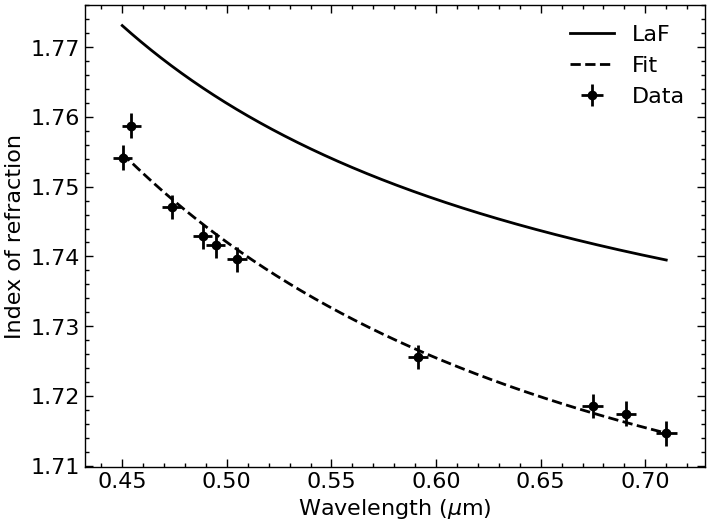

In [87]:
# Lanthanum Flint
def calculate_n_LaF(x):
    term1 = (1.66842615 * x**2) / (x**2 - 0.0103159999)
    term2 = (0.298512803 * x**2) / (x**2 - 0.0469216348)
    term3 = (1.0774376 * x**2) / (x**2 - 82.5078509)
    n_squared_minus_one = term1 + term2 + term3
    n = (n_squared_minus_one + 1)**0.5  # Taking square root to find n
    return n

wavelength_vals = np.linspace(450, 710, 1000)

fig, ax = plt.subplots()
ax.plot(wavelength_vals*10**-3, calculate_n_LaF(wavelength_vals*10**-3), c='k', label='LaF')
ax.errorbar(wavelengths.flatten()*10**6, indices_of_refraction.flatten(), xerr=wavelength_err.flatten()*10**6, yerr=index_err.flatten(), fmt='o', c='k', label='Data')
ax.plot(wavelength_vals*10**-3, f1(odr_output.beta, wavelength_vals*10**-3), c='k', ls='--', label='Fit')
ax.set_xlabel(r"Wavelength ($\mu$m)")
ax.set_ylabel(r"Index of refraction")
ax.legend()
plt.savefig("../figures/LaF_dispersion_curve.pdf", bbox_inches='tight')
plt.show()

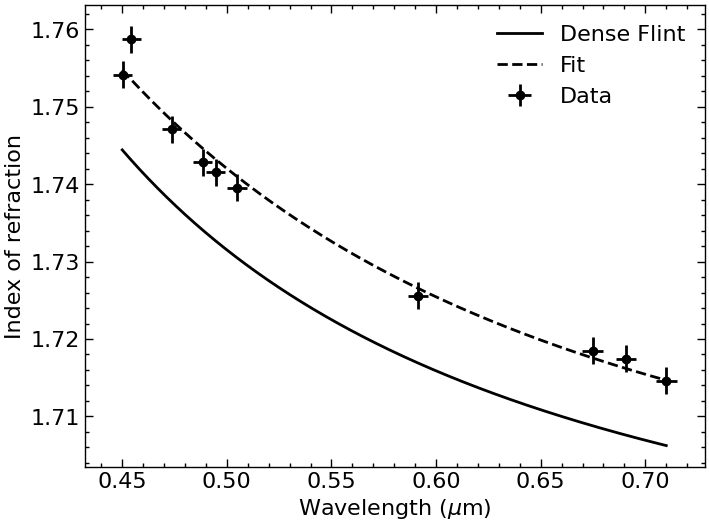

In [88]:
# Dense Flint
def calculate_n_dense_flint(λ):
    term1 = (1.55912923 * λ**2) / (λ**2 - 0.0121481001)
    term2 = (0.284246288 * λ**2) / (λ**2 - 0.0534549042)
    term3 = (0.968842926 * λ**2) / (λ**2 - 112.174809)
    n_squared_minus_one = term1 + term2 + term3
    n = (n_squared_minus_one + 1)**0.5  # Taking square root to find n
    return n

wavelength_vals = np.linspace(450, 710, 1000)

fig, ax = plt.subplots()
ax.plot(wavelength_vals*10**-3, calculate_n_dense_flint(wavelength_vals*10**-3), c='k', label='Dense Flint')
ax.errorbar(wavelengths.flatten()*10**6, indices_of_refraction.flatten(), xerr=wavelength_err.flatten()*10**6, yerr=index_err.flatten(), fmt='o', c='k', label='Data')
ax.plot(wavelength_vals*10**-3, f1(odr_output.beta, wavelength_vals*10**-3), c='k', ls='--', label='Fit')
ax.set_xlabel(r"Wavelength ($\mu$m)")
ax.set_ylabel(r"Index of refraction")
ax.legend()
plt.savefig("../figures/dense_flint_dispersion_curve.pdf", bbox_inches='tight')
plt.show()

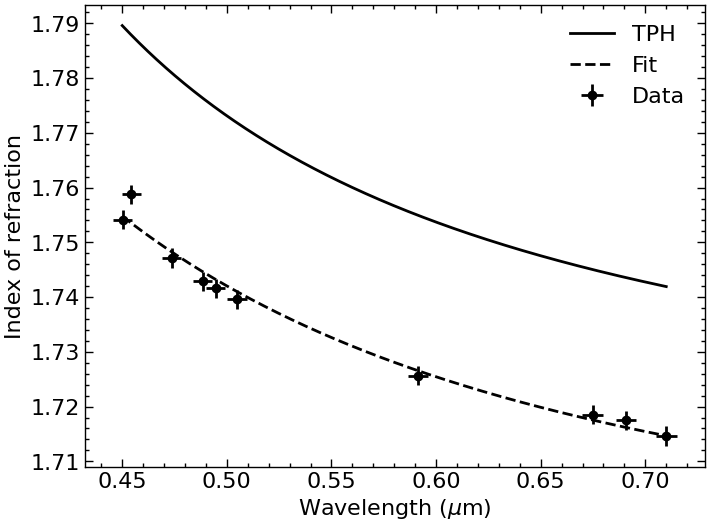

In [89]:
# TPH
def calculate_n_TPH(λ):
    n_squared = 2.9569821 - 0.013856476*λ**2 + 0.037265687*λ**(-2) + \
                0.0029140249*λ**(-4) - 0.00020079792*λ**(-6) + 2.945722e-05*λ**(-8)
    n = n_squared**0.5  # Taking square root to find n
    return n

wavelength_vals = np.linspace(450, 710, 1000)

fig, ax = plt.subplots()
ax.plot(wavelength_vals*10**-3, calculate_n_TPH(wavelength_vals*10**-3), c='k', label='TPH')
ax.errorbar(wavelengths.flatten()*10**6, indices_of_refraction.flatten(), xerr=wavelength_err.flatten()*10**6, yerr=index_err.flatten(), fmt='o', c='k', label='Data')
ax.plot(wavelength_vals*10**-3, f1(odr_output.beta, wavelength_vals*10**-3), c='k', ls='--', label='Fit')
ax.set_xlabel(r"Wavelength ($\mu$m)")
ax.set_ylabel(r"Index of refraction")
ax.legend()
plt.savefig("../figures/TPH_dispersion_curve.pdf", bbox_inches='tight')
plt.show()

Beta: [1.68774069 0.01357371]
Beta Std Error: [0.00241176 0.00064768]
Beta Covariance: [[ 3.48470544e-06 -8.93935228e-07]
 [-8.93935228e-07  2.51312740e-07]]
Residual Variance: 1.6691763045973291
Inverse Condition #: 0.06695040979678887
Reason(s) for Halting:
  Sum of squares convergence


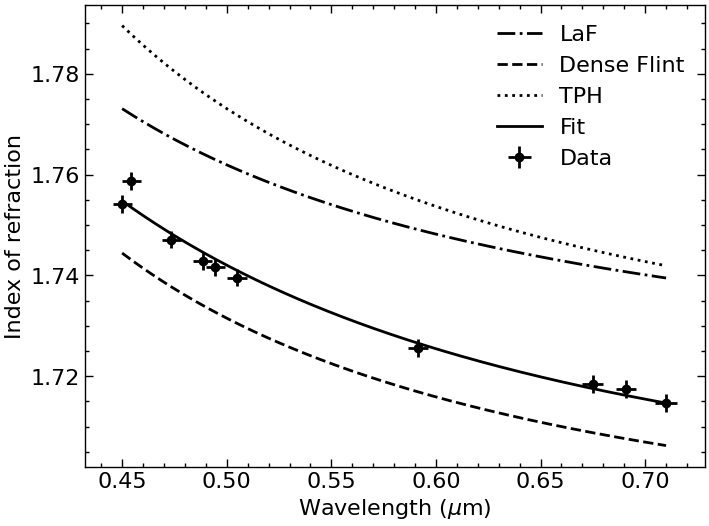

In [80]:
# Put the path three onto the same graph

odr_model = odr.Model(f1)
data = odr.RealData(wavelengths.flatten()*10**6, indices_of_refraction.flatten(), sx=wavelength_err.flatten()*10**6, sy=index_err.flatten())
odr_instance = odr.ODR(data, odr_model, beta0=[1, 1])
odr_instance.set_job(fit_type=2)
odr_output = odr_instance.run()
popt = odr_output.pprint()

fig, ax = plt.subplots()
ax.plot(wavelength_vals*10**-3, calculate_n_LaF(wavelength_vals*10**-3), linestyle='-.' ,c='k', label='LaF')
ax.plot(wavelength_vals*10**-3, calculate_n_dense_flint(wavelength_vals*10**-3), linestyle='--', c='k', label='Dense Flint')
ax.plot(wavelength_vals*10**-3, calculate_n_TPH(wavelength_vals*10**-3), linestyle=':', c='k', label='TPH')
ax.errorbar(wavelengths.flatten()*10**6, indices_of_refraction.flatten(), xerr=wavelength_err.flatten()*10**6, yerr=index_err.flatten(), fmt='o', c='k', label='Data')
ax.plot(wavelength_vals*10**-3, f1(odr_output.beta, wavelength_vals*10**-3), c='k', ls='-', label='Fit')
ax.set_xlabel(r"Wavelength ($\mu$m)")
ax.set_ylabel(r"Index of refraction")
ax.legend()
plt.savefig("../figures/dispersion_curves.pdf", bbox_inches='tight')
plt.show()